In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline

5
0
C:/crs/proj/2015_Sandwich/Sandwich_all_surveys_preliminary/2016-01-25_v1_DEM_10cm.tif
xo,yo:  376056.0 4625535.0
xoff, yoff, xend, yend:  4320 7820 3350 7550
1
C:/crs/proj/2015_Sandwich/Sandwich_all_surveys_preliminary/2016-03-30_DEM_10cm_cropped.tif
xo,yo:  376206.5224272934 4625437.967243103
xoff, yoff, xend, yend:  2814 6314 2379 6579
2
C:/crs/proj/2015_Sandwich/Sandwich_all_surveys_preliminary/2016-09-21_DEM_cropped.tif
xo,yo:  376029.99999727565 4625576.999999732
xoff, yoff, xend, yend:  4580 8080 3769 7969
3
C:/crs/proj/2015_Sandwich/Sandwich_all_surveys_preliminary/2017-01-25_SandwichTNB_v2_DEM_10cm.tif
xo,yo:  376103.0 4625616.0
xoff, yoff, xend, yend:  3850 7350 4160 8360
4
C:/crs/proj/2015_Sandwich/Sandwich_all_surveys_preliminary/2017-01-09_V1_DEM_10cm.tif
xo,yo:  376140.0 4625467.0
xoff, yoff, xend, yend:  3480 6980 2670 6870


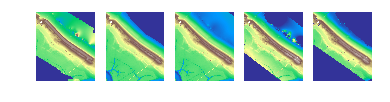

In [2]:
# read into windows
fdir = "C:/crs/proj/2015_Sandwich/Sandwich_all_surveys_preliminary/"
fnames = ("2016-01-25_v1_DEM_10cm.tif",\
          "2016-03-30_DEM_10cm_cropped.tif",\
          "2016-09-21_DEM_cropped.tif",\
          "2017-01-25_SandwichTNB_v2_DEM_10cm.tif",\
          "2017-01-09_V1_DEM_10cm.tif"
          )
nf=len(fnames)
print(nf)

# top left corner of roi (UTM Zone 19N meters)
e0 = 376488.; n0 = 4625200.

# size of roi (colums, rows)
xsize, ysize = 3500, 4200

zw = np.zeros((nf,ysize,xsize))
for i in range(nf):
    print(i)
    print(fdir+fnames[i])
    # open first time to determine origin
    with rasterio.open(fdir+fnames[i]) as src:
        # location of origin (upper left) from transform
        xo,yo = src.transform*(0,0)
        print('xo,yo: ',xo,yo)
        # index of first col, row in window from inverse transform
        xy = ~src.transform*(e0, n0)
        xoff, yoff = int(xy[0]), int(xy[1])
        print("xoff, yoff, xend, yend: ",xoff, xoff+xsize, yoff, yoff+ysize)
        src.close()
    # reopen into specifed window
    with rasterio.open(fdir+fnames[i]) as src:
        # note the x,y switch: syntax for window=((row_start, row_stop)(col_start, col_stop)
        zt = src.read(1, window=((yoff,yoff+ysize),(xoff,xoff+xsize)))
        zw[i::]=zt
        plt.subplot(1,nf,i+1);plt.axis('off');plt.imshow(zt,cmap=plt.cm.terrain,vmin=-2,vmax=8)
        src.close()

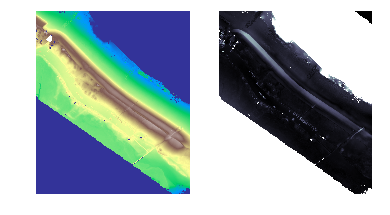

In [3]:
# calculate mean and std. dev. of maps
zmean = np.mean(zw,0)
zstd = np.std(zw,0)
plt.plot(figsize=(6,8))
plt.subplot(1,2,1);plt.axis('off');plt.imshow(zmean[0::],cmap=plt.cm.terrain,vmin=-2,vmax=8)
plt.subplot(1,2,2);plt.axis('off');plt.imshow(zstd[0::],cmap=plt.cm.bone,vmin=0,vmax=2)


In [4]:
# use the last file to define the output coord. ref. system
print(src.crs)
print(src.transform)
profile = {'driver': 'GTiff', 'height': ysize, 'width': xsize, 'count': 1,\
           'dtype': zstd.dtype, 'crs':src.crs, 'transform': src.transform}

CRS({'init': 'epsg:6348'})
| 0.10, 0.00, 376140.00|
| 0.00,-0.10, 4625467.00|
| 0.00, 0.00, 1.00|


In [6]:
# write the tiff file
with rasterio.open('zstd.tif', 'w', **profile) as dst:
    dst.write(zstd, indexes=1)